<a href="https://colab.research.google.com/github/Adya-Mishra/Image-Background-Replacement-using-Stable-Diffusion/blob/main/Image_Generation_and_Background_Replacement_using_Stable_Diffusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Generation and Object Replacement using Stable Diffusion
Author: Adya Mishra  
Date: December 21, 2024

## Project Goals
* Implement object replacement using Stable Diffusion 3
* Create automatic mask generation based on prompts
* Demonstrate seamless object replacement in images

In [ ]:
#install required libraries
!pip install diffusers transformers torch accelerate huggingface_hub

In [216]:
# Hugging Face Login
from huggingface_hub import login
# Get your token from: https://huggingface.co/settings/tokens
login("Your_Hugging_Face_Token")  # Replace with your token

In [217]:
# Import required libraries
import torch
from diffusers import StableDiffusionPipeline, DiffusionPipeline
from diffusers import StableDiffusionInpaintPipeline
from transformers import CLIPSegProcessor, CLIPSegForImageSegmentation
from PIL import Image, ImageFilter
import requests
import io
import numpy as np
import matplotlib.pyplot as plt
import cv2

## Model Loading Functions
The following cells contain functions for loading our required models:
- Base Stable Diffusion 3 model
- Inpainting model
- Segmentation model for mask generation

In [218]:
def load_base_model():
    """
    Loads a quantized version of Stable Diffusion model
    Returns: StableDiffusionPipeline object
    """
    model_id = "stabilityai/stable-diffusion-2-1-base"

    pipe = StableDiffusionPipeline.from_pretrained(
        model_id,
        torch_dtype=torch.float16,
        safety_checker=None
    )

    device = "cuda" if torch.cuda.is_available() else "cpu"
    pipe = pipe.to(device)

    return pipe

In [219]:
def load_inpaint_model():
    """
    Loads the inpainting model for object replacement
    Returns: StableDiffusionInpaintPipeline object
    """
    inpaint_model_id = "stabilityai/stable-diffusion-2-1-base"

    inpaint_pipe = StableDiffusionInpaintPipeline.from_pretrained(
        inpaint_model_id,
        torch_dtype=torch.float16,
        safety_checker=None
    )

    device = "cuda" if torch.cuda.is_available() else "cpu"
    inpaint_pipe = inpaint_pipe.to(device)

    return inpaint_pipe

In [220]:
def load_segment_model():
    """
    Loads the CLIP segmentation model for automatic mask generation
    Returns: Processor and Model for segmentation
    """
    processor = CLIPSegProcessor.from_pretrained("CIDAS/clipseg-rd64-refined")
    model = CLIPSegForImageSegmentation.from_pretrained("CIDAS/clipseg-rd64-refined")

    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = model.to(device)

    return processor, model

## Mask Generation and Object Replacement
The following cells implement the core functionality:
- Automatic mask generation based on text prompts
- Object replacement using the generated mask
- Result visualization

In [221]:
def generate_mask(image, text_prompt, processor, model):
    """
    Generates a refined binary mask for the specified object in the image.
    Args:
        image: PIL Image
        text_prompt: String describing the object to mask.
        processor: CLIPSeg processor.
        model: CLIPSeg model.
    Returns: Refined binary mask as a PIL Image.
    """
    # Get original image dimensions
    width, height = image.size

    # Prepare inputs
    inputs = processor(
        images=image,
        text=[text_prompt],
        padding="max_length",
        return_tensors="pt"
    ).to(model.device)

    # Generate prediction
    with torch.no_grad():
        outputs = model(**inputs)
        preds = outputs.logits

    # Convert to binary mask
    mask = torch.sigmoid(preds)
    mask = mask.cpu().numpy().squeeze()
    mask = (mask > 0.3).astype(np.uint8) * 255

    # Resize mask to match original image dimensions
    mask = cv2.resize(mask, (width, height))

    # Apply morphological operations
    kernel = np.ones((7,7), np.uint8)
    mask = cv2.dilate(mask, kernel, iterations=2)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=2)

    # Apply Gaussian blur and threshold
    mask = cv2.GaussianBlur(mask, (11,11), 3)
    mask = (mask > 127).astype(np.uint8) * 255

    return Image.fromarray(mask)

In [222]:
def replace_object(image_path, object_prompt, replacement_prompt, processor, seg_model, inpaint_pipe):
    # Load image
    image = Image.open(image_path)

    # Convert to RGB if needed
    if image.mode != 'RGB':
        image = image.convert('RGB')

    # Store original dimensions
    original_width, original_height = image.size

    # Resize for processing if needed
    max_size = 768
    if max(image.size) > max_size:
        ratio = max_size / max(image.size)
        new_size = tuple(int(dim * ratio) for dim in image.size)
        image = image.resize(new_size, Image.LANCZOS)

    # Generate mask
    mask = generate_mask(image, object_prompt, processor, seg_model)
    mask_np = np.array(mask)

    # Refine mask
    kernel_close = np.ones((9,9), np.uint8)
    kernel_open = np.ones((5,5), np.uint8)
    mask_np = cv2.morphologyEx(mask_np, cv2.MORPH_CLOSE, kernel_close)
    mask_np = cv2.morphologyEx(mask_np, cv2.MORPH_OPEN, kernel_open)
    mask_np = cv2.dilate(mask_np, kernel_open, iterations=2)
    _, mask_np = cv2.threshold(mask_np, 127, 255, cv2.THRESH_BINARY)

    # Ensure mask matches image dimensions
    mask_np = cv2.resize(mask_np, (image.size[0], image.size[1]))

    # Generate replacement
    result = inpaint_pipe(
        prompt=replacement_prompt,
        image=image,
        mask_image=Image.fromarray(mask_np),
        num_inference_steps=75,
        guidance_scale=9.0,
        negative_prompt="blur, hazy, transparent, ghost, spectral"
    ).images[0]

    def improved_poisson_blend(original, mask, replacement):
        """
        Enhanced Poisson blending with proper dimension handling.
        """
        # Convert all images to numpy arrays
        original_np = np.array(original.convert("RGB"))
        replacement_np = np.array(replacement.convert("RGB"))
        mask_np = np.array(mask)

        # Ensure all images have the same dimensions
        height, width = original_np.shape[:2]
        replacement_np = cv2.resize(replacement_np, (width, height))
        mask_np = cv2.resize(mask_np, (width, height))

        # Ensure mask is binary
        _, mask_np = cv2.threshold(mask_np, 127, 255, cv2.THRESH_BINARY)

        # Create blending mask
        kernel = np.ones((7,7), np.uint8)
        blend_mask = cv2.dilate(mask_np, kernel, iterations=1)
        blend_mask = cv2.GaussianBlur(blend_mask, (5,5), 0)

        # Calculate center point using moments
        moments = cv2.moments(mask_np)
        if moments["m00"] != 0:
            center_x = int(moments["m10"] / moments["m00"])
            center_y = int(moments["m01"] / moments["m00"])
        else:
            center_x, center_y = width // 2, height // 2

        # Ensure center is well within bounds
        center_x = min(max(width // 4, center_x), width * 3 // 4)
        center_y = min(max(height // 4, center_y), height * 3 // 4)

        try:
            # Attempt seamless cloning
            mixed_clone = cv2.seamlessClone(
                replacement_np,
                original_np,
                blend_mask,
                (center_x, center_y),
                cv2.MIXED_CLONE
            )
        except cv2.error:
            print("Falling back to alpha blending...")
            # Convert mask to 3-channel float
            blend_mask = cv2.cvtColor(blend_mask, cv2.COLOR_GRAY2BGR).astype(float) / 255.0

            # Perform alpha blending
            mixed_clone = (replacement_np * blend_mask +
                         original_np * (1 - blend_mask)).astype(np.uint8)

        # Enhance result
        result = cv2.addWeighted(mixed_clone, 0.9, original_np, 0.1, 0)

        # Local contrast enhancement
        mask_area = cv2.dilate(mask_np, kernel, iterations=2)
        lab = cv2.cvtColor(result, cv2.COLOR_RGB2LAB)
        l, a, b = cv2.split(lab)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        l = clahe.apply(l)
        enhanced = cv2.merge([l, a, b])
        enhanced = cv2.cvtColor(enhanced, cv2.COLOR_LAB2RGB)

        # Final blending
        mask_area = mask_area.astype(float) / 255
        mask_area = cv2.merge([mask_area, mask_area, mask_area])
        final = result * (1 - mask_area) + enhanced * mask_area

        return Image.fromarray(final.astype(np.uint8))

    # Perform blending
    blended = improved_poisson_blend(image, Image.fromarray(mask_np), result)

    # Resize back to original dimensions if needed
    if (original_width, original_height) != image.size:
        blended = blended.resize((original_width, original_height), Image.LANCZOS)

    return image, Image.fromarray(mask_np), blended


In [223]:
def display_results(original, mask, result):
    """
    Displays the original image, mask, and result side by side
    """
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

    ax1.imshow(original)
    ax1.set_title('Original Image')
    ax1.axis('off')

    ax2.imshow(mask, cmap='gray')
    ax2.set_title('Generated Mask')
    ax2.axis('off')

    ax3.imshow(result)
    ax3.set_title('Result')
    ax3.axis('off')

    plt.show()

Loading models...


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Processing image...


  0%|          | 0/75 [00:00<?, ?it/s]

Displaying results...


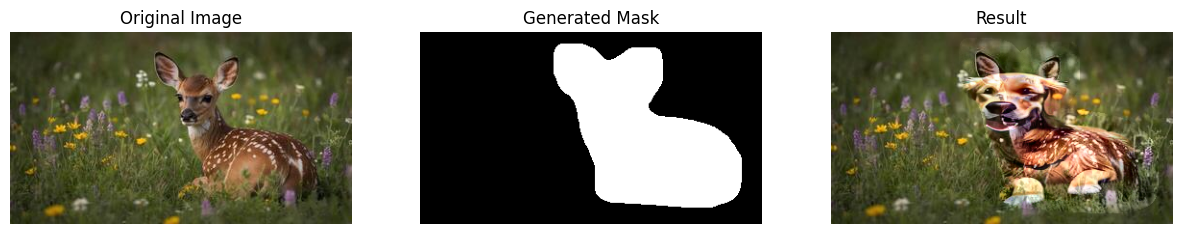

Result saved as 'result.png'


In [225]:
def main():
    print("Loading models...")
    processor, seg_model = load_segment_model()
    inpaint_pipe = load_inpaint_model()

    image_path = "/content/Deer.jpg"  #image to be edited
    object_prompt = "Deer"  #object to be replaced
    replacement_prompt = "a cute golden retriever dog lying down in grass, same pose as a resting deer, photorealistic, detailed fur, clear edges, high quality, natural lighting"

    print("Processing image...")
    original, mask, result = replace_object(
        image_path,
        object_prompt,
        replacement_prompt,
        processor,
        seg_model,
        inpaint_pipe
    )

    print("Displaying results...")
    display_results(original, mask, result)
    result.save("result.png")
    print("Result saved as 'result.png'")

if __name__ == "__main__":
    main()